<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 - Skin Cancer Detection

> Authors: Cher Wee Zheng, Ng Wei, Ryan Yong

**Summary:**   
- Develop a Neural Network model to differentiate whether the skin abnormality in the image is malignant or benign .
- Training data: Malignant and Benign samples

There are a total of 4 notebooks for this project:  
 1. `01_EDA.ipynb`   
 2. `02_Data_Modelling.ipynb`   
 3. `03_Hyperparameter_Tuning.ipynb`

---
**This Notebook**
- Imports the image data
- Performs Exploratory Data Analysis (EDA) including visualisation and augmentation for some of the samples.
- Plots the histogram of pixel intensity value for training dataset and each RGB value.

**Data**
- The data used in this project is from [Kaggle](https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/data)

Importing necessary libraries

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.color import rgb2gray

Importing images from the directory.
Use ImageDataGenerator to rescale the image.
`display_image_of_class` is the function created to display each Malignant and Benign class

Found 2000 images belonging to 2 classes.


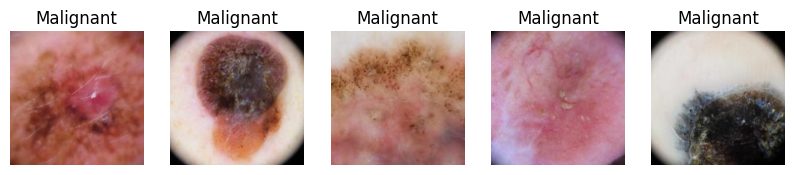

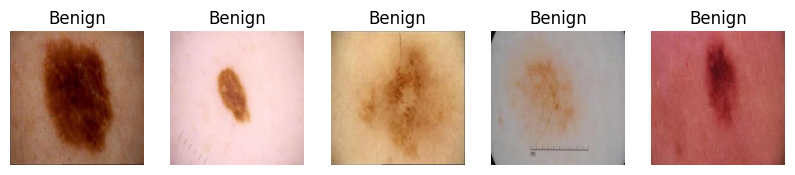

In [2]:
# Define constants
image_size = (224, 224)  # Rescale images to 224x224 pixels
batch_size = 10  # Adjusted to ensure we have enough images to find at least 5 of each class

# Path to the dataset
test_dir = '../data/test'

# Define a data generator with only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator for the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep the data in order to make it easier to filter specific classes
)

# Function to display images of a specific class
def display_images_of_class(class_label, num_images=5):
    # Get class indices
    class_indices = test_generator.class_indices

    # Inverse mapping of class indices to class labels
    inverse_class_indices = {v: k for k, v in class_indices.items()}
    
    # Get the index of the class we are interested in
    target_index = class_indices[class_label]
    
    # Initialize a counter for the images displayed
    images_displayed = 0
    
    # Plot images from the specified class
    plt.figure(figsize=(10, 2))
    for images, labels in test_generator:
        for i, label in enumerate(labels):
            if label[target_index] == 1:
                plt.subplot(1, num_images, images_displayed + 1)
                plt.imshow(images[i])
                plt.title(class_label)
                plt.axis('off')
                images_displayed += 1
                
                if images_displayed == num_images:
                    plt.show()
                    return
        if images_displayed == num_images:
            break

# Display images for each class of interest
for class_label in ['Malignant', 'Benign']:
    display_images_of_class(class_label)


Displaying 5 samples from the training dataset of `Malignant` and `Benign`, we can see that the malignant skin abnormalities are usually darker than benign ones.  

Image pre-processing with `image augmentation` 

Found 2000 images belonging to 2 classes.


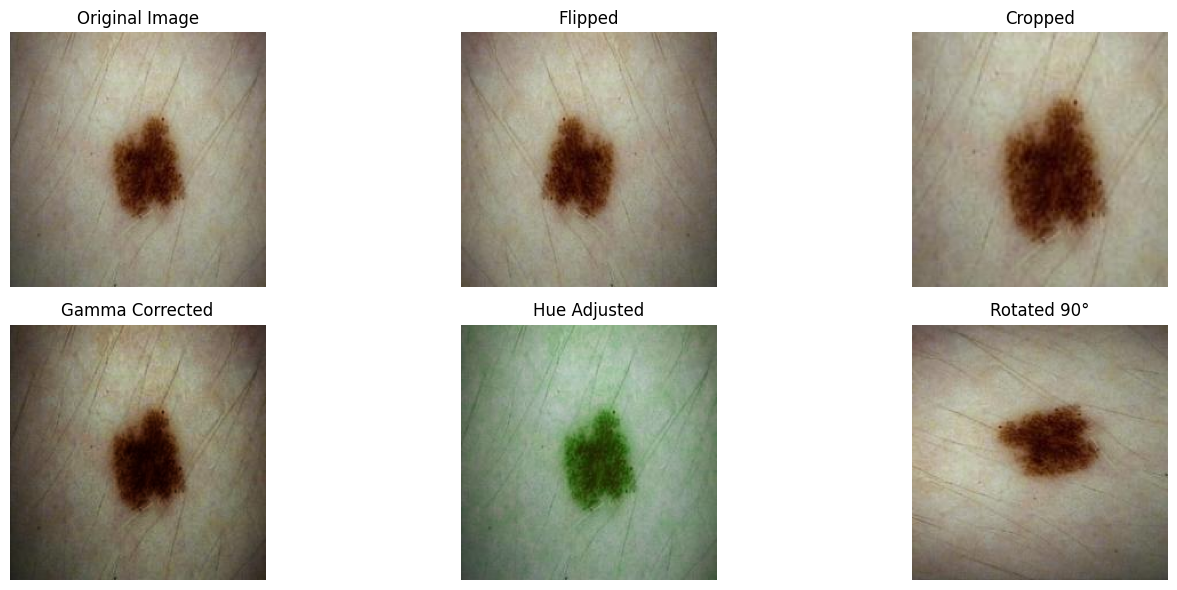

In [5]:
# Define your image_size and batch_size if not already defined
image_size = (224, 224)
batch_size = 10

# Path to dataset
test_dir = '../data/test'

# Create a data generator for the original image
original_datagen = ImageDataGenerator(rescale=1./255)

# Load a random 'Benign' image
original_generator = original_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Shuffle to get a random image
)

def adjust_gamma(image, gamma=1.0):
    # Applying gamma correction
    gamma = tf.cast(gamma, dtype=tf.float32)
    image = tf.image.adjust_gamma(image, gamma=gamma)
    return image

def adjust_hue(image, hue=0.0):
    # Applying hue adjustment
    image = tf.image.adjust_hue(image, delta=hue)
    return image

# Find a 'Benign' image
for images, labels in original_generator:
    for i, label in enumerate(labels):
        if label[original_generator.class_indices['Benign']] == 1:
            benign_image = images[i]  # This is a rescaled image (1./255)
            plt.figure(figsize=(15, 6))
            
            # Display the original image
            plt.subplot(2, 3, 1)
            plt.imshow(benign_image)
            plt.title('Original Image')
            plt.axis('off')
            
            # Apply and display flipping
            flipped_image = tf.image.flip_left_right(benign_image)
            plt.subplot(2, 3, 2)
            plt.imshow(flipped_image)
            plt.title('Flipped')
            plt.axis('off')
            
            # Apply and display cropping
            cropped_image = tf.image.central_crop(benign_image, central_fraction=0.7)
            plt.subplot(2, 3, 3)
            plt.imshow(cropped_image)
            plt.title('Cropped')
            plt.axis('off')
            
            # Apply and display gamma correction
            gamma_corrected = adjust_gamma(benign_image, gamma=1.5)
            plt.subplot(2, 3, 4)
            plt.imshow(gamma_corrected)
            plt.title('Gamma Corrected')
            plt.axis('off')
            
            # Apply and display hue adjustment
            hue_adjusted = adjust_hue(benign_image, hue=0.2)
            plt.subplot(2, 3, 5)
            plt.imshow(hue_adjusted)
            plt.title('Hue Adjusted')
            plt.axis('off')
            
            # Apply and display rotation
            rotated_image = tf.image.rot90(benign_image)
            plt.subplot(2, 3, 6)
            plt.imshow(rotated_image)
            plt.title('Rotated 90°')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Stop after displaying the first found 'Benign' image and its augmentations
            break
    break


From a single image, through image augmentation, 5 other images are generated: flipped, cropped, gamma corrected. hue adjusted and rotated 90 degrees.These additional images help our models to improve prediction accuracy and  generalization ability.

Plot the histogram of pixel intensity value (RGB and Greyscale) for `Benign` & `Malignant` classes.

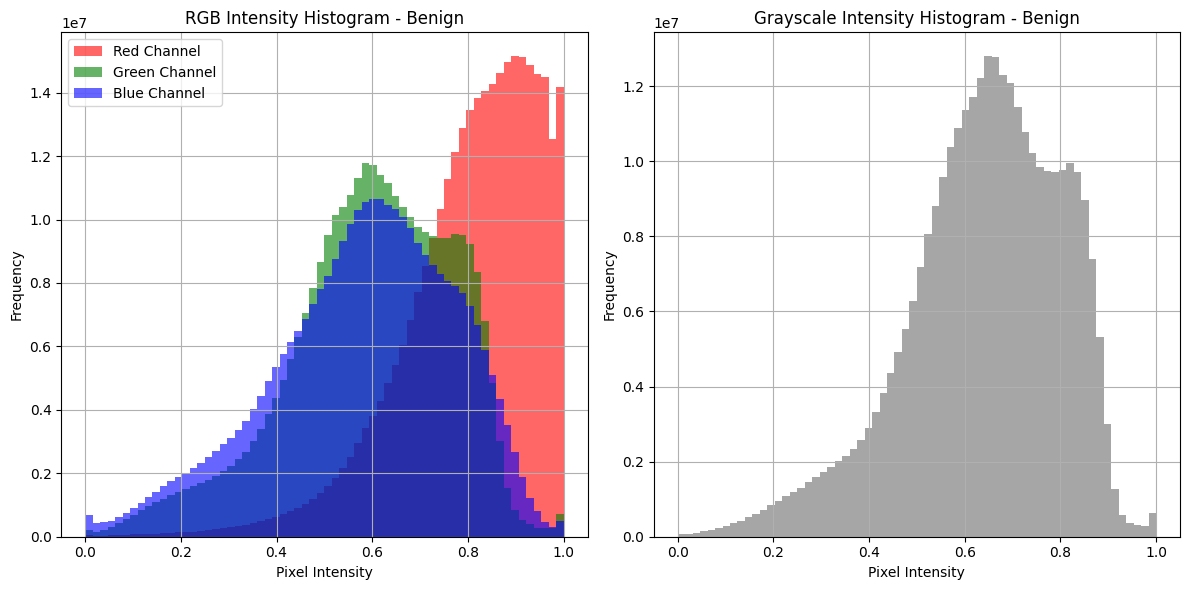

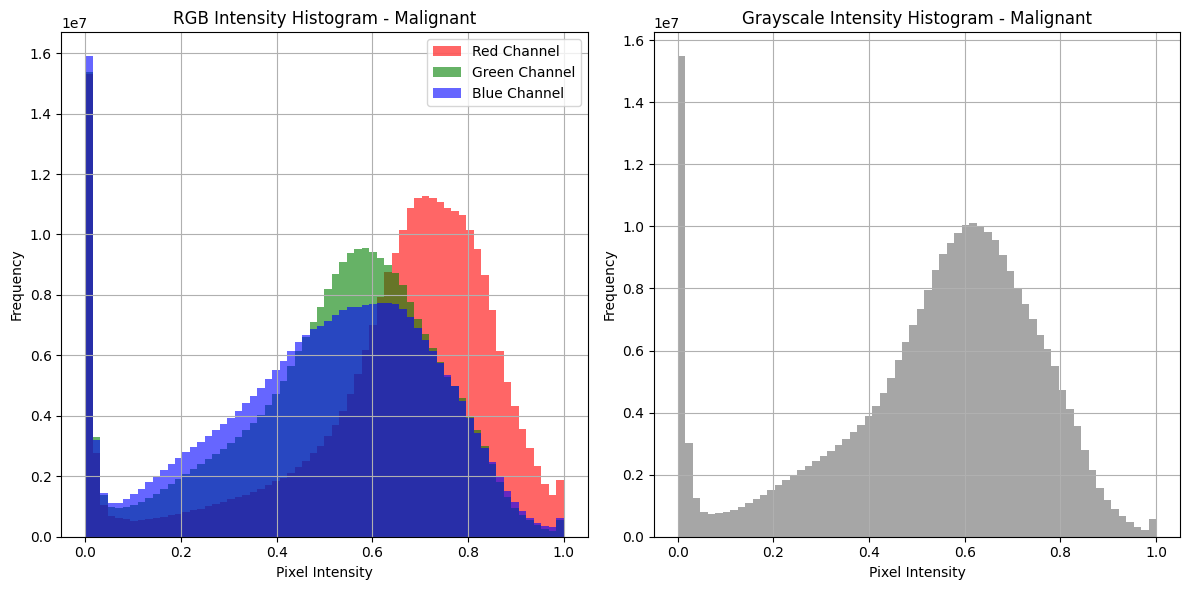

In [36]:

# Define constants
test_dir = '../data/train'  # Adjust this path to your dataset
classes = ['Benign', 'Malignant']  # Ensure these match the folder names exactly
image_size = (224, 224)  # Define your image size (width, height)

def process_class_images(class_dir):
    # Initialize an array to store all pixel values for RGB and grayscale histograms
    all_pixels_rgb = np.array([])
    all_pixels_gray = np.array([])
    
    # Load images
    for file in os.listdir(class_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_dir, file)
            img = load_img(img_path, target_size=image_size, color_mode='rgb')
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            img_array_flat = img_array.reshape(-1, 3)
            
            # Append pixel values for RGB histogram
            all_pixels_rgb = np.concatenate([all_pixels_rgb, img_array_flat], axis=0) if all_pixels_rgb.size else img_array_flat
            
            # Convert to grayscale and append pixel values for grayscale histogram
            gray_img = rgb2gray(img_array)
            all_pixels_gray = np.concatenate([all_pixels_gray, gray_img.flatten()], axis=0) if all_pixels_gray.size else gray_img.flatten()

    return all_pixels_rgb, all_pixels_gray

# Plot histograms
def plot_histograms(class_name, pixels_rgb, pixels_gray):
    plt.figure(figsize=(12, 6))
    
    # RGB Histogram
    plt.subplot(1, 2, 1)
    plt.hist(pixels_rgb[:, 0], bins=64, color='red', alpha=0.6, label='Red Channel')
    plt.hist(pixels_rgb[:, 1], bins=64, color='green', alpha=0.6, label='Green Channel')
    plt.hist(pixels_rgb[:, 2], bins=64, color='blue', alpha=0.6, label='Blue Channel')
    plt.title(f'RGB Intensity Histogram - {class_name}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    # Grayscale Histogram
    plt.subplot(1, 2, 2)
    plt.hist(pixels_gray, bins=64, color='gray', alpha=0.7)
    plt.title(f'Grayscale Intensity Histogram - {class_name}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Process each class and display results
for class_name in classes:
    class_dir = os.path.join(test_dir, class_name)
    pixels_rgb, pixels_gray = process_class_images(class_dir)
    plot_histograms(class_name, pixels_rgb, pixels_gray)

    # average of 200 min runtime

Above are the histograms of Benign and Malignant images. Based on the histogram, we can observe that the Benign images tend to be redder and brighter, as shown by the higher intensity of RGB pixels. Malignant images' pixels tend to be more dark, as we can observe that the highest number of pixels have 0 intensity. Benign images tend to be more “red” than Malignant, as most red pixels fll under > 0.75 intensity. Besides the black pixels in Malignant, both Green and Blue are mostly distributed in between 0.45 - 0.7 intensity.

Now we move on to compare the pixel distribution for individual `Benign` and `Malignant` images.

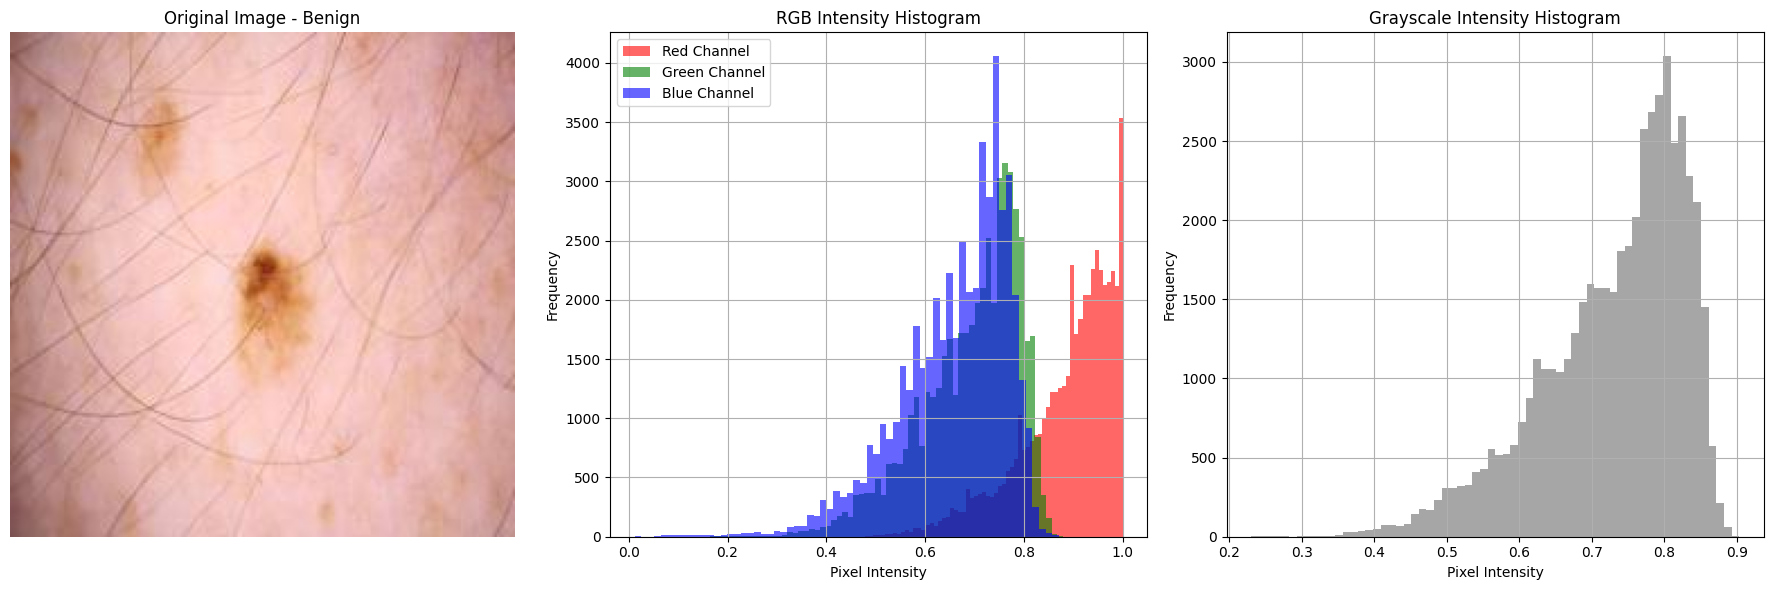

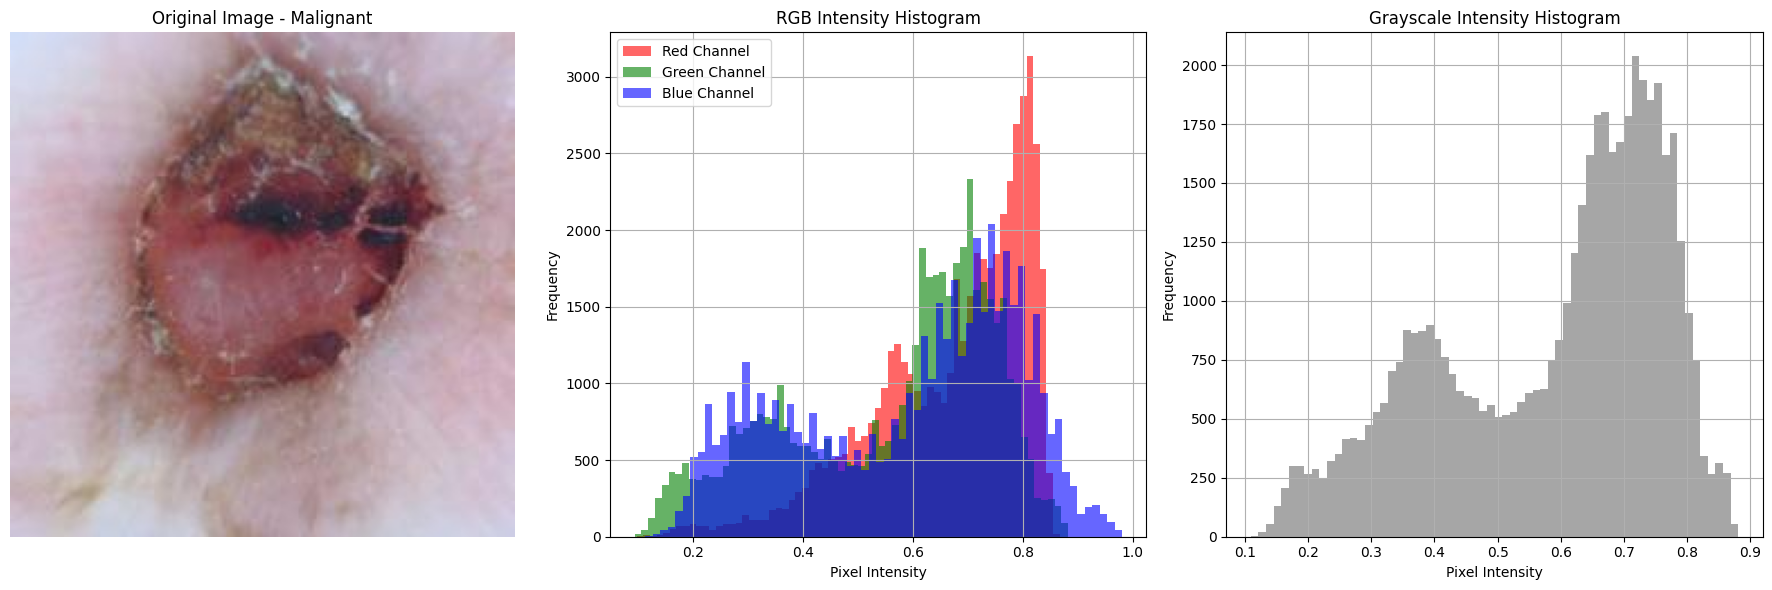

In [26]:
# Define constants
test_dir = '../data/train'  # Adjust this path to your dataset
classes = ['Benign', 'Malignant']  # Ensure these match the folder names exactly
image_size = (224, 224)  # Define your image size (width, height)

#  Load Image function with random selection
def load_one_image_per_class(class_name):
    class_dir = os.path.join(test_dir, class_name)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if image_files:
        random_file = random.choice(image_files)  # Randomly select an image file
        img_path = os.path.join(class_dir, random_file)
        img = load_img(img_path, target_size=image_size, color_mode='rgb')
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        return img_array
    
    return None


def plot_image_and_histograms(class_name, img_array):
    # Convert the image to grayscale for the grayscale histogram
    img_gray = rgb2gray(img_array)
    
    # Setting up the figure for three subplots: original image, RGB histogram, and grayscale histogram
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Display the original image
    axs[0].imshow(img_array)
    axs[0].set_title(f'Original Image - {class_name}')
    axs[0].axis('off')  # Hide the axis for the image
    
    # RGB Histogram
    axs[1].hist(img_array[..., 0].ravel(), bins=64, color='red', alpha=0.6, label='Red Channel')
    axs[1].hist(img_array[..., 1].ravel(), bins=64, color='green', alpha=0.6, label='Green Channel')
    axs[1].hist(img_array[..., 2].ravel(), bins=64, color='blue', alpha=0.6, label='Blue Channel')
    axs[1].set_title('RGB Intensity Histogram')
    axs[1].set_xlabel('Pixel Intensity')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()
    axs[1].grid(True)
    
    # Grayscale Histogram
    axs[2].hist(img_gray.ravel(), bins=64, color='gray', alpha=0.7)
    axs[2].set_title('Grayscale Intensity Histogram')
    axs[2].set_xlabel('Pixel Intensity')
    axs[2].set_ylabel('Frequency')
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Load and plot for each class
for class_name in classes:
    img_array = load_one_image_per_class(class_name)
    if img_array is not None:
        plot_image_and_histograms(class_name, img_array)
    else:
        print(f"No images found for class {class_name}.")

As mentioned above, `Malignant` images tend to be darker, and so we can see that overall the pixel intensity is lower compared to the `Benign` image.

As we know, all images are a combination of 3-color-channels RGB. We now break it down furhter into 3 images to see how each channel looks like.

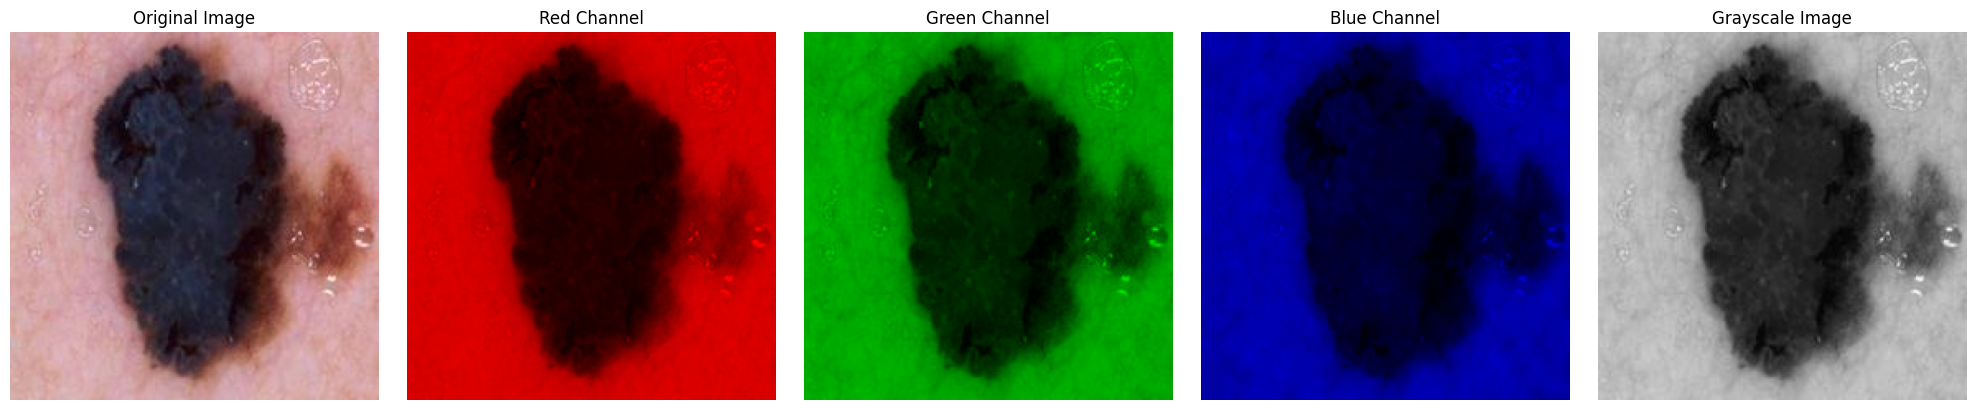

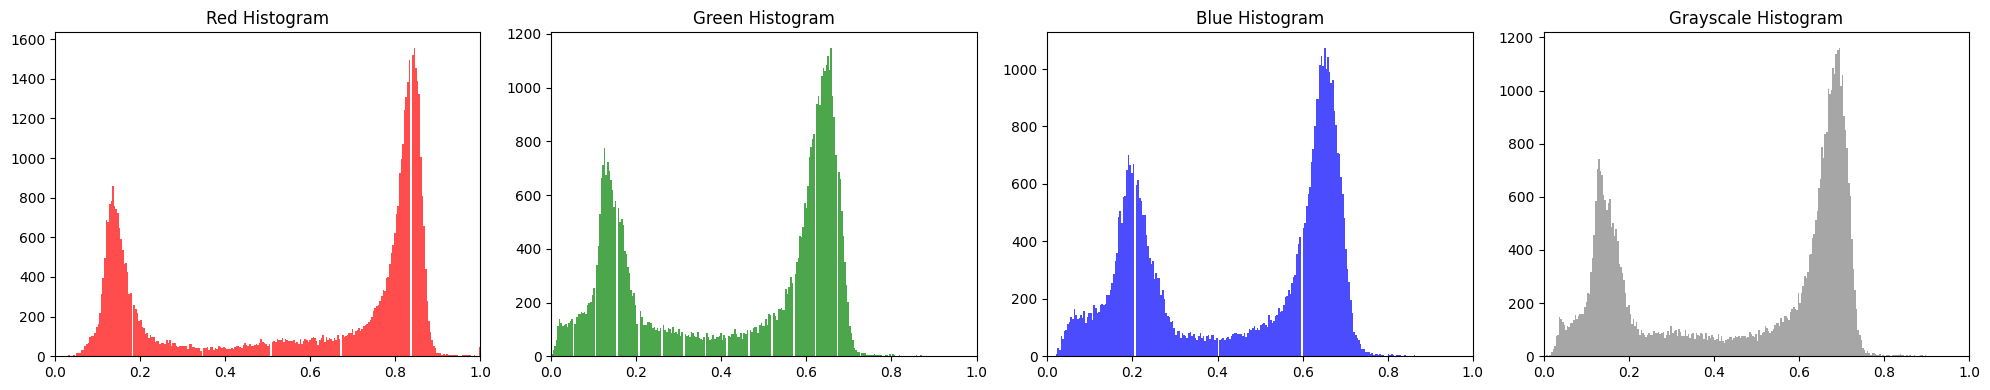

In [10]:
# Define constants
test_dir = '../data/train/Malignant'  # Adjust this path to your 'Malignant' images directory
image_size = (224, 224)  # Desired image size

def load_random_image(image_directory):
    """Loads a random image from a specified directory."""
    image_files = [file for file in os.listdir(image_directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        random_file = random.choice(image_files)
        img_path = os.path.join(image_directory, random_file)
        img = load_img(img_path, target_size=image_size, color_mode='rgb')
        return img_to_array(img) / 255.0
    else:
        return None

def display_image_and_channels(img_array):
    """Displays the original, R, G, B, and Grayscale versions of an image."""
    if img_array is None:
        print("Image not found.")
        return
    
    gray_img = rgb2gray(img_array)
    
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    # Display the original image
    axs[0].imshow(img_array)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    # Display R, G, B channels
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        temp_img = np.zeros(img_array.shape, dtype=np.float32)
        temp_img[..., i] = img_array[..., i]
        axs[i + 1].imshow(temp_img)
        axs[i + 1].set_title(f'{color} Channel')
        axs[i + 1].axis('off')
    
    # Display grayscale image
    axs[4].imshow(gray_img, cmap='gray')
    axs[4].set_title('Grayscale Image')
    axs[4].axis('off')
    
    plt.tight_layout()
    plt.show()

def display_histograms(img_array):
    """Displays the RGB and Grayscale histograms of an image."""
    if img_array is None:
        print("Image not found.")
        return
    
    gray_img = rgb2gray(img_array)
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 4), tight_layout=True)

    # RGB histograms
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        axs[i].hist(img_array[..., i].ravel(), bins=256, color=color.lower(), alpha=0.7)
        axs[i].set_title(f'{color} Histogram')
        axs[i].set_xlim([0, 1])

    # Grayscale histogram
    axs[3].hist(gray_img.ravel(), bins=256, color='gray', alpha=0.7)
    axs[3].set_title('Grayscale Histogram')
    axs[3].set_xlim([0, 1])
    
    plt.show()

# Load a random 'Malignant' image
random_malignant_image = load_random_image(test_dir)

# First, display the image and its channels
display_image_and_channels(random_malignant_image)

# Then, display the histograms for the image
display_histograms(random_malignant_image)

We can see images of different RGB colors and their corresponding histograms.

We know from previous dataset's histograms that `Benign` iamges have red pixels mostly > 0.75 intensity, and the least number of pixels at at 0 intensity for all 3 RGB colors. For `Malignant` images, the highest frequency of pixels for the RGB values is at 0, and the red pixel peaks at 0.75. With this information, we proceed to find out the outliers in the data.
- `Benign` outlier would be RGB < 0.35
- `Malignant` outlier would be R > 0.75 and GB > 0.45

Let's now check the average of RGB values across the `Benign` and `Malignant` images.

In [13]:
# Calculate average RGB values for each category
benign_dir = os.path.join(test_dir, 'Benign')
malignant_dir = os.path.join(test_dir, 'Malignant')
average_rgb_benign = calculate_average_rgb(benign_dir)
average_rgb_malignant = calculate_average_rgb(malignant_dir)

print(f"'Benign' Average RGB: R: {average_rgb_benign[0]:.4f}, G: {average_rgb_benign[1]:.4f}, B: {average_rgb_benign[2]:.4f}")
print(f"'Malignant' Average RGB: R: {average_rgb_malignant[0]:.4f}, G: {average_rgb_malignant[1]:.4f}, B: {average_rgb_malignant[2]:.4f}")

'Benign' Average RGB: R: 0.8058, G: 0.5961, B: 0.5811
'Malignant' Average RGB: R: 0.6301, G: 0.5100, B: 0.4917


The code below will display the top 5 outliers of `Benign` and `Malignant` images based on the RGB value.

In [14]:
def calculate_image_average_rgb(img_path):
    """Calculate the average RGB values of a single image."""
    img = load_img(img_path, target_size=image_size, color_mode='rgb')
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return np.mean(img_array, axis=(0, 1))

def find_and_sort_outliers(directory, criteria, top_n=5):
    """
    Find outliers based on specific criteria and sort them.
    - For 'Benign', find images with average RGB below 0.35 and sort by lowest RGB.
    - For 'Malignant', find images with R > 0.7 and G&B > 0.45, then sort by highest RGB.
    """
    outliers = []
    
    for file in os.listdir(directory):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory, file)
            avg_rgb = calculate_image_average_rgb(img_path)
            
            if criteria == 'benign' and np.all(avg_rgb < 0.35):
                outliers.append((file, np.mean(avg_rgb)))
            elif criteria == 'malignant' and (avg_rgb[0] > 0.7 and avg_rgb[1] > 0.45 and avg_rgb[2] > 0.45):
                outliers.append((file, np.mean(avg_rgb)))
    
    # Sort based on criteria
    if criteria == 'benign':
        # Sort by lowest RGB value for benign
        outliers = sorted(outliers, key=lambda x: x[1])
    else:
        # Sort by highest RGB value for malignant
        outliers = sorted(outliers, key=lambda x: x[1], reverse=True)
    
    # Return the top N outliers
    return outliers[:top_n]

# Redefine directories
test_dir = '../data/train'  # Adjust this path to your dataset
benign_dir = os.path.join(test_dir, 'Benign')
malignant_dir = os.path.join(test_dir, 'Malignant')

# Find top 5 outliers
benign_outliers_top_5 = find_and_sort_outliers(benign_dir, 'benign', top_n=5)
malignant_outliers_top_5 = find_and_sort_outliers(malignant_dir, 'malignant', top_n=5)

# Display the top 5 outliers for each category
print("Top 5 Benign Outliers (Lowest RGB):")
for outlier in benign_outliers_top_5:
    print(outlier[0], f"with Average RGB: {outlier[1]:.4f}")

print("\nTop 5 Malignant Outliers (Highest RGB):")
for outlier in malignant_outliers_top_5:
    print(outlier[0], f"with Average RGB: {outlier[1]:.4f}")

# To display these images, you would load and show them using matplotlib as previously shown.


Top 5 Benign Outliers (Lowest RGB):
4627.jpg with Average RGB: 0.1075
5211.jpg with Average RGB: 0.1407
5160.jpg with Average RGB: 0.1901
3573.jpg with Average RGB: 0.2018
2089.jpg with Average RGB: 0.2164

Top 5 Malignant Outliers (Highest RGB):
2474.jpg with Average RGB: 0.8788
5119.jpg with Average RGB: 0.8773
1028.jpg with Average RGB: 0.8727
5291.jpg with Average RGB: 0.8702
52.jpg with Average RGB: 0.8689


Displaying Top 5 Benign Outliers:


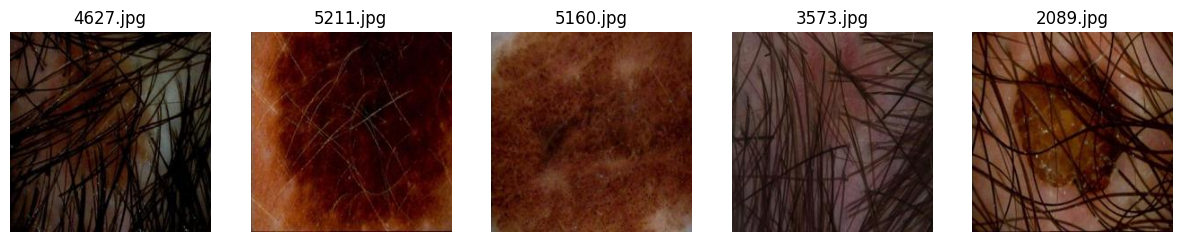

Displaying Top 5 Malignant Outliers:


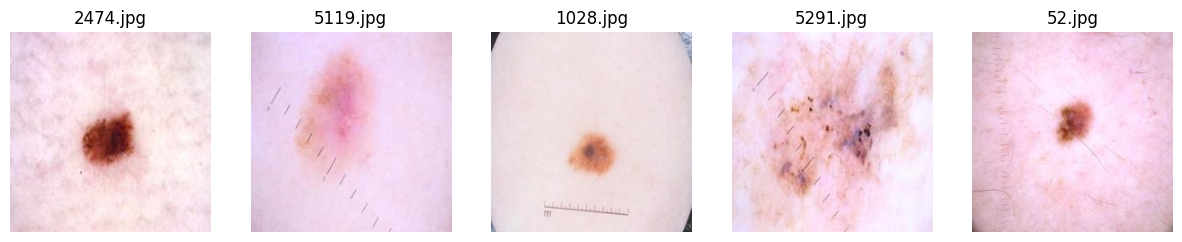

In [15]:
def display_specific_outliers(directory, outliers):
    """Display specific outliers."""
    plt.figure(figsize=(15, 3))
    for i, (filename, _) in enumerate(outliers):
        img_path = os.path.join(directory, filename)
        img = load_img(img_path)
        plt.subplot(1, len(outliers), i + 1)
        plt.imshow(img)
        plt.title(filename)
        plt.axis('off')
    plt.show()

# Display top 5 benign outliers
print("Displaying Top 5 Benign Outliers:")
display_specific_outliers(benign_dir, benign_outliers_top_5)

# Display top 5 malignant outliers
print("Displaying Top 5 Malignant Outliers:")
display_specific_outliers(malignant_dir, malignant_outliers_top_5)